# Bidirectional LSTM Network without Attention





## Loading Data

In [2]:

import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [3]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)


aclImdb_v1.tar.gz:   0%|          | 81.9k/84.1M [00:00<01:45, 794kB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 54.2MB/s]


In [4]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [5]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                          
100%|█████████▉| 398818/400000 [00:16<00:00, 24644.53it/s]

In [6]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Defining Model

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()      
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)     
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)   
        packed_output, (hidden, cell) = self.rnn(packed_embedded)  
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)     
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))         
        return self.fc(hidden)

In [22]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
model.to(device)

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [23]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [24]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [25]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.7464,  0.1909, -0.1596,  ...,  0.5039, -0.1181,  0.7585],
        [-0.0789,  0.6782,  0.5625,  ..., -0.5039, -0.0752,  0.9482],
        [-0.4096, -0.5753,  0.1126,  ...,  0.4092,  0.1856,  0.1066]],
       device='cuda:0')

In [26]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.7464,  0.1909, -0.1596,  ...,  0.5039, -0.1181,  0.7585],
        [-0.0789,  0.6782,  0.5625,  ..., -0.5039, -0.0752,  0.9482],
        [-0.4096, -0.5753,  0.1126,  ...,  0.4092,  0.1856,  0.1066]],
       device='cuda:0')


In [27]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [28]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [29]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


In [43]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths.cpu()).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [47]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths.cpu()).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [48]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [50]:
N_EPOCHS = 5

train_l = []
valid_l = []
train_a =[]
valid_a = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_l.append(train_loss)
    train_a.append(train_acc)

    valid_l.append(valid_loss)
    valid_a.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 41s
	Train Loss: 0.350 | Train Acc: 85.64%
	 Val. Loss: 0.352 |  Val. Acc: 84.04%
Epoch: 02 | Epoch Time: 0m 41s
	Train Loss: 0.298 | Train Acc: 87.57%
	 Val. Loss: 0.334 |  Val. Acc: 85.79%
Epoch: 03 | Epoch Time: 0m 41s
	Train Loss: 0.255 | Train Acc: 89.97%
	 Val. Loss: 0.295 |  Val. Acc: 88.67%
Epoch: 04 | Epoch Time: 0m 41s
	Train Loss: 0.233 | Train Acc: 91.07%
	 Val. Loss: 0.303 |  Val. Acc: 88.74%
Epoch: 05 | Epoch Time: 0m 41s
	Train Loss: 0.195 | Train Acc: 92.75%
	 Val. Loss: 0.276 |  Val. Acc: 89.37%


In [58]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.284 | Test Acc: 88.83%


In [83]:
confusion_matrix = [[0,0],[0,0]]
tpr = []
fpr = []
pred = []
label = []

with torch.no_grad():
    
        for batch in test_iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths.cpu()).squeeze(1)
            y = batch.label
            rounded_preds = torch.round(torch.sigmoid(predictions))
            y = y.tolist()
            p = rounded_preds.tolist()
            
            

            for i in range(len(p)):
              confusion_matrix[int(y[i])][int(p[i])] += 1
              pred.append(int(p[i]))
              label.append(int(y[i]))

            t = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[0][1] +0.0001)
            f = confusion_matrix[0][1]/(confusion_matrix[1][1] + confusion_matrix[0][1]+ 0.0001)

            tpr.append(t)
            fpr.append(f)
            



print('-------Confusion Matrix-------')
for i in confusion_matrix:
  for j in i:
    print(j,end='   ')
  print()

-------Confusion Matrix-------
10805   1695   
1099   11401   


## Training Loss & Validation Loss vs No. of Epochs curve

In [52]:
import matplotlib.pyplot as plt

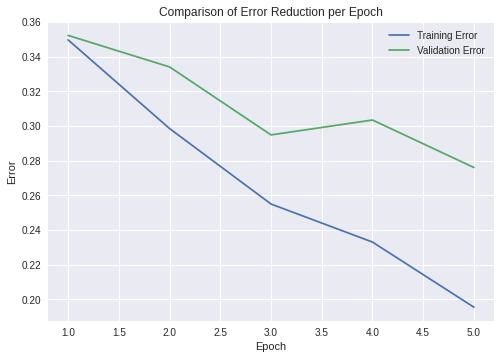

In [54]:

plt.style.use("seaborn")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Comparison of Error Reduction per Epoch")

x = [i for i in range(1,6)]


plt.plot(x,train_l,label="Training Error")
plt.plot(x,valid_l,label="Validation Error")

plt.legend()
plt.savefig('./Error.png')
plt.show()

## Training Loss & Validation Accuracy vs No. of Epochs curve

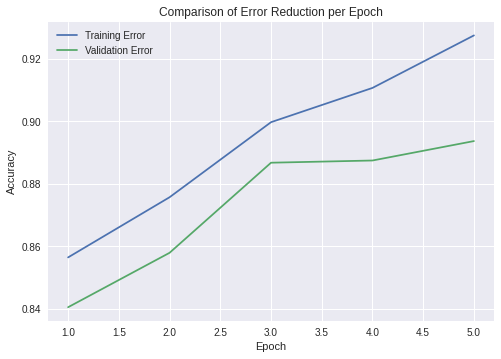

In [55]:
plt.style.use("seaborn")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Error Reduction per Epoch")

x = [i for i in range(1,6)]


plt.plot(x,train_a,label="Training Error")
plt.plot(x,valid_a,label="Validation Error")

plt.legend()
plt.savefig('./Acc.png')
plt.show()

## Confusion Matrix

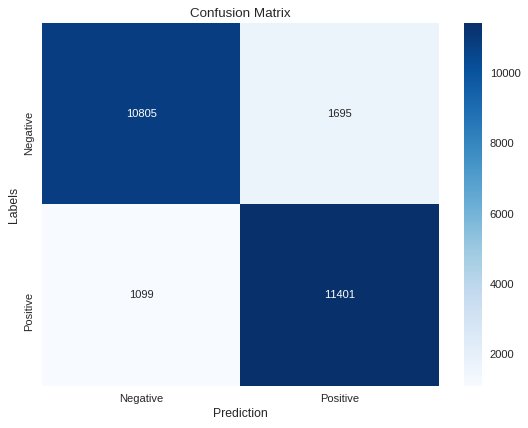

In [64]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


x_axis_labels= ['Negative','Positive']
y_axis_labels= ['Negative','Positive']


sn.heatmap(confusion_matrix, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cmap='Blues', fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Labels")
plt.title('Confusion Matrix')
plt.savefig('./Confusion_matrix')
plt.show()


## ROC CURVE

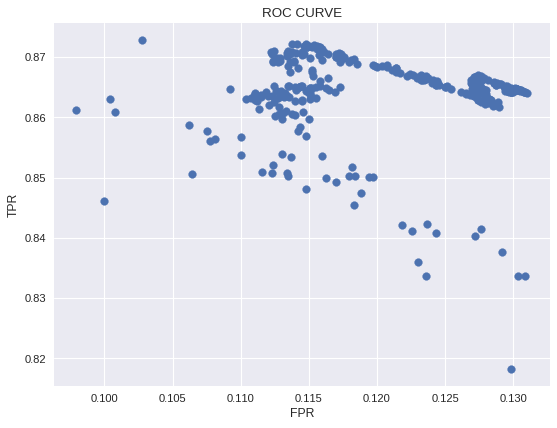

In [79]:
# ROC CURVE {receiver operating characteristic curve}


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC CURVE')
plt.savefig('./ROC_CURVE')
plt.show()



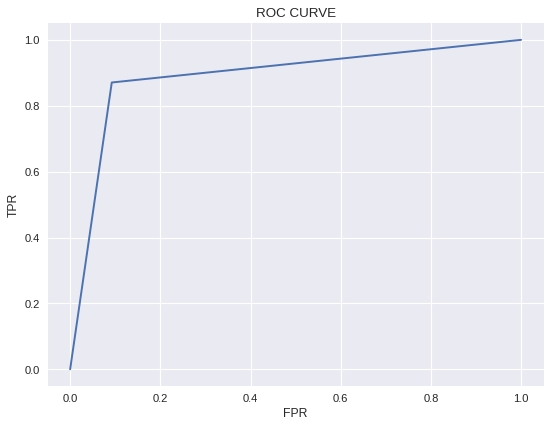

In [84]:
 # ROC CURVE {receiver operating characteristic curve}
from  sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(pred, label)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC CURVE')
plt.savefig('./ROC_CURVE')
plt.show()

In [85]:
thresholds

array([2, 1, 0])

## Precision-Recall Curve

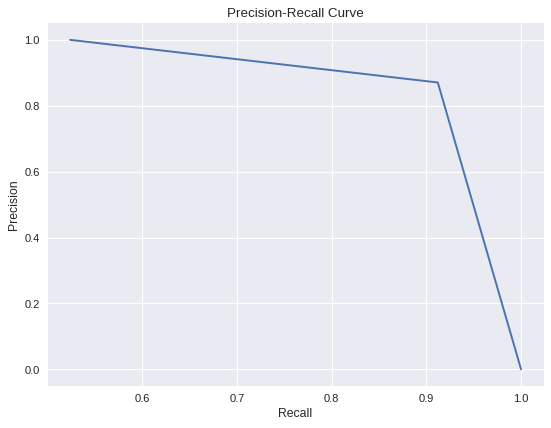

In [87]:
# ROC CURVE {receiver operating characteristic curve}
from  sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(pred, label)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(precision,recall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.savefig('./PRC_CURVE')
plt.show()